In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [4]:
with open("../umbra/data/umbra_contract_txs.json", "r") as file:
    contract_txs = json.load(file)["result"] #all the transactions' details related to the umbra contract

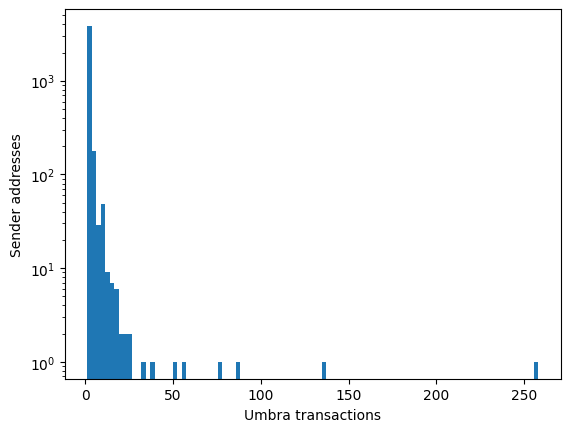

In [5]:
txs_to_contract = []

for c in contract_txs:
    txs_to_contract.append(c["from"])

adresses_of_txs_to_contract_series = pd.Series(txs_to_contract, name="Txs count grouped by addressess")
adresses_of_txs_to_contract_count = adresses_of_txs_to_contract_series.value_counts()
df = pd.DataFrame({"Address": adresses_of_txs_to_contract_count.index, "Count": adresses_of_txs_to_contract_count.values})

plt.hist(adresses_of_txs_to_contract_count.values,bins=100)
plt.ylabel('Sender addresses')
plt.xlabel('Umbra transactions')
plt.yscale("log")
#print(mean(adresses_of_txs_to_contract_count.values))

In [6]:
#df.plot.axes.get_xaxis().set_visible(False)
# ax = df.plot.bar(rot=0, figsize=(20,10))
# ax.set(xticklabels=[])
# plt.yscale('log')
# plt.show()

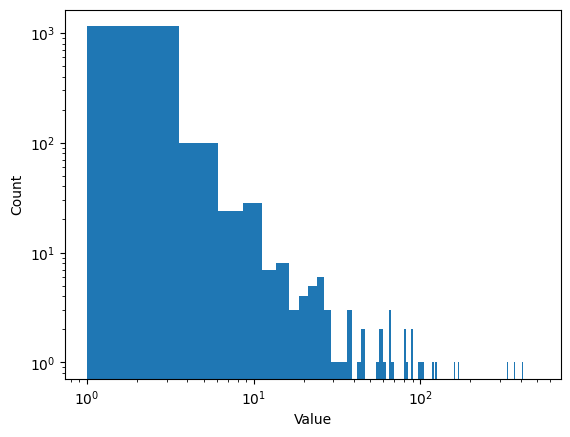

In [7]:
#Sent eth

amounts = []

for d in contract_txs:
    if d["functionName"] == "sendEth(address _receiver, uint256 _tollCommitment, bytes32 _pkx, bytes32 _ciphertext)":
        amounts.append(int(d["value"])/pow(10, 18))

amounts = pd.Series(amounts, name="Wei amounts")
amounts_count = amounts.value_counts()
df = pd.DataFrame({"Sent eth": amounts_count.index, "Sender Addresses": amounts_count.values})

plt.hist(amounts_count.values,bins=200)
plt.ylabel('Count')
plt.xlabel('Value')
plt.yscale("log")
plt.xscale("log")

In [11]:
sys.path.append('../umbra/')
import sys
from helper import Access
from get_ens_name import get_ens_name
import json

with open("../umbra/data/umbra_contract_txs.json", "r") as file:
    contract_txs = json.load(file)["result"]

with open("../umbra/data/stealth_key_registry_contract_txs.json", "r") as file:
    stealth_contract_txs = json.load(file)["result"]

ens_database = "../umbra/data/ens_database.json"

with open(ens_database, "r") as file:
    ens_db = json.load(file)

In [12]:
#Are there stealth addresses that have been used more then once?

from collections import Counter
    
addresses = []

for d in contract_txs:
    if d["functionName"] == "withdrawTokenOnBehalf(address _stealthAddr, address _acceptor, address _tokenAddr, address _sponsor, uint256 _sponsorFee, uint8 _v, bytes32 _r, bytes32 _s)" or d["functionName"] == "":
        continue

    addresses.append(d[d["functionName"]]["_receiver"])

addresses_count = dict(Counter(addresses))

print(list(filter(lambda d: addresses_count[d] > 1, addresses_count)))

[]


In [17]:
# When the receiver address of the eth/token has an address which has communicated with stealth registry

skr_addresses = list(map(lambda d: d["from"], stealth_contract_txs))

chain = []

for d in contract_txs:
    
    if d["functionName"] == "sendEth(address _receiver, uint256 _tollCommitment, bytes32 _pkx, bytes32 _ciphertext)":
        stealth = d[d["functionName"]]["_receiver"]
        for tx in d[d["functionName"]][stealth]:
            if tx["to"] in skr_addresses:
                a_append = {"sender_tx": d["hash"],
                            "receiver_tx": tx["hash"],
                            "receiver_address": tx["to"]}
                if "receiver_ens" in tx:
                    chain.append({**a_append, **{"ens": tx["receiver_ens"]}})
                else:
                    chain.append(a_append)
    elif d["functionName"] == "withdrawTokenOnBehalf(address _stealthAddr, address _acceptor, address _tokenAddr, address _sponsor, uint256 _sponsorFee, uint8 _v, bytes32 _r, bytes32 _s)":
        receiver = d[d["functionName"]]["_acceptor"]
        if receiver in skr_addresses:
            a_append = {"sender_tx": d["hash"],
                        "receiver_tx": d["hash"],
                        "receiver_address": receiver}
            if "receiver_ens" in d[d["functionName"]]:
                chain.append({**a_append, **{"ens": d[d["functionName"]]["receiver_ens"]}})
            else:
                chain.append(a_append)


with open("results/receivers_in_skr.json", "w") as file:
    json.dump(chain, file)

with open("results/receivers_in_skr_ens.json", "w") as file:
    json.dump(list(filter(lambda i: "ens" in i, chain)), file)


In [15]:
skr_ens = []

for d in stealth_contract_txs:
    if "ens" in d:
        skr_ens.append(d["ens"])

with open("results/skr_ens.json", "w") as file:
    json.dump(skr_ens, file)

In [19]:
# Collector Pattern

stealth_withdraw_txs = {}

for d in contract_txs:
    
    if d["functionName"] == "sendEth(address _receiver, uint256 _tollCommitment, bytes32 _pkx, bytes32 _ciphertext)":

        stealth = d[d["functionName"]]["_receiver"]
        
        for tx in d[d["functionName"]][stealth]:
            
            if tx["to"] not in stealth_withdraw_txs: 
                stealth_withdraw_txs[tx["to"]] = {}
                if "receiver_ens" in tx: stealth_withdraw_txs[tx["to"]]["ens"] = tx["receiver_ens"]
                stealth_withdraw_txs[tx["to"]]["collection_count"] = 0
                stealth_withdraw_txs[tx["to"]]["stealths"] = []

            stealth_withdraw_txs[tx["to"]]["stealths"].append(stealth)
            stealth_withdraw_txs[tx["to"]]["collection_count"] += 1

    elif d["functionName"] == "withdrawTokenOnBehalf(address _stealthAddr, address _acceptor, address _tokenAddr, address _sponsor, uint256 _sponsorFee, uint8 _v, bytes32 _r, bytes32 _s)":

        func = d[d["functionName"]]
        receiver = func["_acceptor"]

        if receiver not in stealth_withdraw_txs: 
            stealth_withdraw_txs[receiver] = {}
            if "receiver_ens" in func: stealth_withdraw_txs[receiver]["ens"] = func["receiver_ens"]
            stealth_withdraw_txs[receiver]["collection_count"] = 0
            stealth_withdraw_txs[receiver]["stealths"] = []

        stealth_withdraw_txs[receiver]["stealths"].append(func["_stealthAddr"])
        stealth_withdraw_txs[receiver]["collection_count"] += 1


with open("results/collector_pattern.json", "w") as file:
    json.dump(stealth_withdraw_txs, file)


Text(0.5, 0, 'No. of addresses')

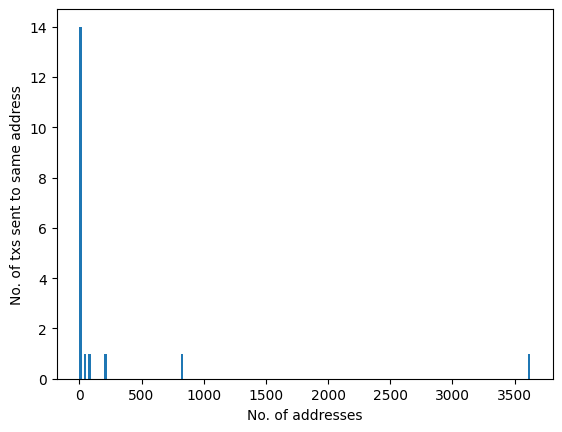

In [33]:
with open("results/collector_pattern.json", "r") as file:
    collection_counts = json.load(file)

amounts = list(map(lambda d: d["collection_count"], collection_counts.values()))

amounts = pd.Series(amounts, name="Collector Pattern: Counts")
amounts_count = amounts.value_counts()
df = pd.DataFrame({"Sent eth": amounts_count.index, "Sender Addresses": amounts_count.values})

plt.hist(amounts_count.values,bins=200)
plt.ylabel('No. of txs sent to same address')
plt.xlabel('No. of addresses')